# 📈 مشروع ESRGAN لتحسين دقة الصور باستخدام بيانات DIV2K (محلية)
دفتر Jupyter احترافي لتحميل البيانات، بناء النموذج، تدريبه، وتقييم الأداء باستخدام PSNR و SSIM.

## 1. استيراد المكتبات

In [1]:
# ✅ Install required libraries (if not already installed)
!pip install torch torchvision matplotlib pillow scikit-image tqdm --quiet

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

## 2. تحميل بيانات DIV2K من المجلد المحلي

In [4]:

# ⚠️ قم بتعديل المسارات حسب جهازك
lr_dir = '../data/DIV2K_valid_LR_bicubic'
hr_dir = '../data/DIV2K_valid_HR'

# تحويلات مختلفة للـ LR و HR
transform_lr = transforms.Compose([
    transforms.Resize((64, 64)),  # لتتناسب مع ESRGAN input
    transforms.ToTensor()
])

transform_hr = transforms.Compose([
    transforms.Resize((256, 256)),  # لتتناسب مع مخرجات ESRGAN
    transforms.ToTensor()
])

class DIV2KDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, transform_lr=None, transform_hr=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform_lr = transform_lr
        self.transform_hr = transform_hr
        self.files = sorted(os.listdir(lr_dir))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        lr_path = os.path.join(self.lr_dir, self.files[idx])
        hr_path = os.path.join(self.hr_dir, self.files[idx].replace('x4', ''))
        lr_img = Image.open(lr_path).convert('RGB')
        hr_img = Image.open(hr_path).convert('RGB')
        if self.transform_lr:
            lr_img = self.transform_lr(lr_img)
        if self.transform_hr:
            hr_img = self.transform_hr(hr_img)
        return lr_img, hr_img

# تحميل البيانات
dataset = DIV2KDataset(lr_dir, hr_dir, transform_lr=transform_lr, transform_hr=transform_hr)
loader = DataLoader(dataset, batch_size=2, shuffle=True)


## 3. بناء نموذج ESRGAN

In [5]:
class ResidualDenseBlock(nn.Module):
    def __init__(self, nf=64, gc=32):
        super().__init__()
        self.conv1 = nn.Conv2d(nf, gc, 3, 1, 1)
        self.conv2 = nn.Conv2d(nf + gc, gc, 3, 1, 1)
        self.conv3 = nn.Conv2d(nf + 2 * gc, gc, 3, 1, 1)
        self.conv4 = nn.Conv2d(nf + 3 * gc, gc, 3, 1, 1)
        self.conv5 = nn.Conv2d(nf + 4 * gc, nf, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(torch.cat([x, x1], 1)))
        x3 = self.lrelu(self.conv3(torch.cat([x, x1, x2], 1)))
        x4 = self.lrelu(self.conv4(torch.cat([x, x1, x2, x3], 1)))
        x5 = self.conv5(torch.cat([x, x1, x2, x3, x4], 1))
        return x + x5 * 0.2

class RRDB(nn.Module):
    def __init__(self, nf, gc=32):
        super().__init__()
        self.rdb1 = ResidualDenseBlock(nf, gc)
        self.rdb2 = ResidualDenseBlock(nf, gc)
        self.rdb3 = ResidualDenseBlock(nf, gc)

    def forward(self, x):
        return x + self.rdb3(self.rdb2(self.rdb1(x))) * 0.2

class ESRGANGenerator(nn.Module):
    def __init__(self, in_nc=3, out_nc=3, nf=64, nb=5, gc=32):
        super().__init__()
        self.conv_first = nn.Conv2d(in_nc, nf, 3, 1, 1)
        self.rrdb_blocks = nn.Sequential(*[RRDB(nf, gc) for _ in range(nb)])
        self.trunk_conv = nn.Conv2d(nf, nf, 3, 1, 1)
        self.upconv1 = nn.Conv2d(nf, nf, 3, 1, 1)
        self.upconv2 = nn.Conv2d(nf, nf, 3, 1, 1)
        self.conv_last = nn.Conv2d(nf, out_nc, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        fea = self.conv_first(x)
        trunk = self.trunk_conv(self.rrdb_blocks(fea))
        fea = fea + trunk
        fea = self.lrelu(F.interpolate(self.upconv1(fea), scale_factor=2))
        fea = self.lrelu(F.interpolate(self.upconv2(fea), scale_factor=2))
        return self.conv_last(fea)

## 4. تدريب النموذج

Epoch 1/100: 100%|██████████| 50/50 [01:06<00:00,  1.33s/it]


✅ End of Epoch 1, Average Loss: 0.1521


Epoch 2/100: 100%|██████████| 50/50 [01:04<00:00,  1.30s/it]


✅ End of Epoch 2, Average Loss: 0.0866


Epoch 3/100: 100%|██████████| 50/50 [01:05<00:00,  1.32s/it]


✅ End of Epoch 3, Average Loss: 0.0754


Epoch 4/100: 100%|██████████| 50/50 [01:05<00:00,  1.30s/it]


✅ End of Epoch 4, Average Loss: 0.0698


Epoch 5/100: 100%|██████████| 50/50 [01:04<00:00,  1.30s/it]


✅ End of Epoch 5, Average Loss: 0.0679


Epoch 6/100: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


✅ End of Epoch 6, Average Loss: 0.0627


Epoch 7/100: 100%|██████████| 50/50 [01:04<00:00,  1.28s/it]


✅ End of Epoch 7, Average Loss: 0.0602


Epoch 8/100: 100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


✅ End of Epoch 8, Average Loss: 0.0605
⏳ No improvement for 1 epoch(s)


Epoch 9/100: 100%|██████████| 50/50 [01:04<00:00,  1.28s/it]


✅ End of Epoch 9, Average Loss: 0.0575


Epoch 10/100: 100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


✅ End of Epoch 10, Average Loss: 0.0553


Epoch 11/100: 100%|██████████| 50/50 [01:04<00:00,  1.28s/it]


✅ End of Epoch 11, Average Loss: 0.0548


Epoch 12/100: 100%|██████████| 50/50 [01:04<00:00,  1.28s/it]


✅ End of Epoch 12, Average Loss: 0.0540


Epoch 13/100: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


✅ End of Epoch 13, Average Loss: 0.0530


Epoch 14/100: 100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


✅ End of Epoch 14, Average Loss: 0.0547
⏳ No improvement for 1 epoch(s)


Epoch 15/100: 100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


✅ End of Epoch 15, Average Loss: 0.0528


Epoch 16/100: 100%|██████████| 50/50 [01:04<00:00,  1.28s/it]


✅ End of Epoch 16, Average Loss: 0.0511


Epoch 17/100: 100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


✅ End of Epoch 17, Average Loss: 0.0490


Epoch 18/100: 100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


✅ End of Epoch 18, Average Loss: 0.0495
⏳ No improvement for 1 epoch(s)


Epoch 19/100: 100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


✅ End of Epoch 19, Average Loss: 0.0486


Epoch 20/100: 100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


✅ End of Epoch 20, Average Loss: 0.0480


Epoch 21/100: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


✅ End of Epoch 21, Average Loss: 0.0467


Epoch 22/100: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


✅ End of Epoch 22, Average Loss: 0.0495
⏳ No improvement for 1 epoch(s)


Epoch 23/100: 100%|██████████| 50/50 [01:03<00:00,  1.27s/it]


✅ End of Epoch 23, Average Loss: 0.0480
⏳ No improvement for 2 epoch(s)


Epoch 24/100: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


✅ End of Epoch 24, Average Loss: 0.0500
⏳ No improvement for 3 epoch(s)


Epoch 25/100: 100%|██████████| 50/50 [01:04<00:00,  1.29s/it]


✅ End of Epoch 25, Average Loss: 0.0484
⏳ No improvement for 4 epoch(s)


Epoch 26/100: 100%|██████████| 50/50 [01:03<00:00,  1.28s/it]


✅ End of Epoch 26, Average Loss: 0.0498
⏳ No improvement for 5 epoch(s)
⛔ Early stopping triggered at epoch 26
💾 Model saved to ../models/esrgan_generator.pth


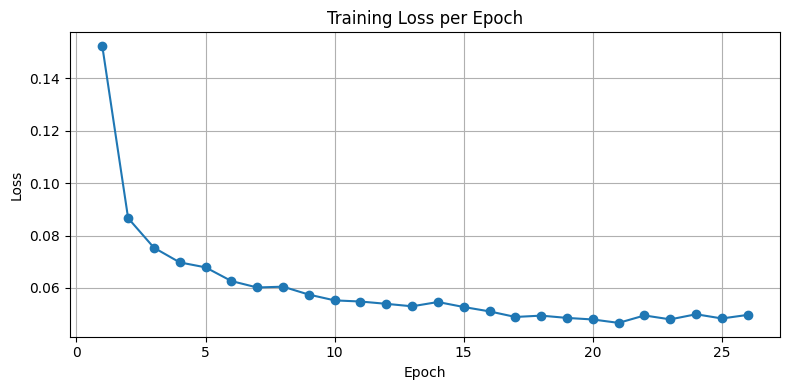

In [6]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ESRGANGenerator().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.L1Loss()

epochs = 100
patience = 5
min_delta = 1e-4

train_losses = []
best_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for lr_imgs, hr_imgs in tqdm(loader, desc=f"Epoch {epoch+1}/{epochs}"):
        lr_imgs, hr_imgs = lr_imgs.to(device), hr_imgs.to(device)
        preds = model(lr_imgs)
        loss = loss_fn(preds, hr_imgs)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(loader)
    train_losses.append(avg_loss)
    print(f"✅ End of Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")

    if best_loss - avg_loss > min_delta:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"⏳ No improvement for {patience_counter} epoch(s)")

    if patience_counter >= patience:
        print(f"⛔ Early stopping triggered at epoch {epoch+1}")
        break

# Save model
os.makedirs("../models", exist_ok=True)
torch.save(model.state_dict(), "../models/esrgan_generator.pth")
print("💾 Model saved to ../models/esrgan_generator.pth")

# Plot loss
if train_losses:
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
    plt.title("Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No loss data to plot.")


## تجربة على بيانات من مسار

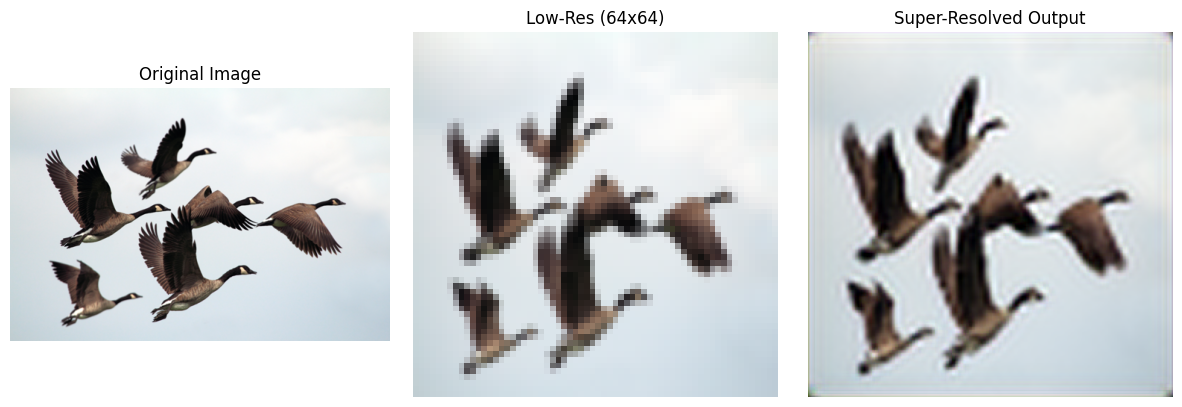

In [11]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# ✅ Load trained model
model = ESRGANGenerator().to(device)
model.load_state_dict(torch.load("../models/esrgan_generator.pth", map_location=device,weights_only=False))
model.eval()

# ✅ Load new image from your device
img_path = "../data/1.png"  # ← replace with your image path
input_img = Image.open(img_path).convert("RGB")

# ✅ Preprocess image to 64x64 as expected by ESRGAN
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
lr_img = transform(input_img)

# ✅ Run model
with torch.no_grad():
    input_tensor = lr_img.unsqueeze(0).to(device)
    output = model(input_tensor).squeeze().cpu().clamp(0, 1)

# ✅ Display original, low-res, and result
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(to_pil_image(lr_img))
plt.title("Low-Res (64x64)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(to_pil_image(output))
plt.title("Super-Resolved Output")
plt.axis("off")

plt.tight_layout()
plt.show()

## 5. تقييم النموذج وعرض النتائج

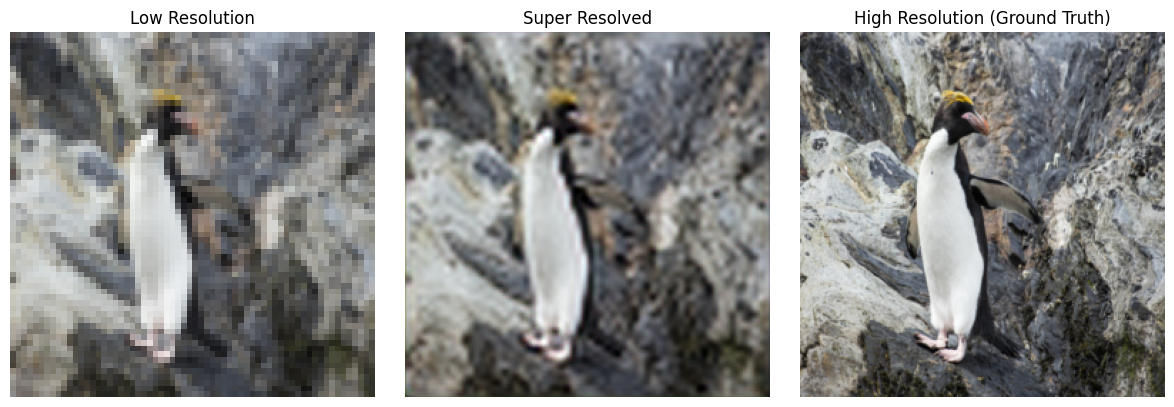

PSNR: 22.88
SSIM: 0.5057


In [13]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Evaluation
model.eval()
lr_img, hr_img = dataset[0]

with torch.no_grad():
    input_tensor = lr_img.unsqueeze(0).to(device)
    output = model(input_tensor).squeeze().cpu().clamp(0, 1)

# Display images
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(to_pil_image(lr_img))
plt.title('Low Resolution')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(to_pil_image(output))
plt.title('Super Resolved')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(to_pil_image(hr_img))
plt.title('High Resolution (Ground Truth)')
plt.axis('off')

plt.tight_layout()
plt.show()

# Compute PSNR and SSIM
sr_np = output.permute(1, 2, 0).numpy()
hr_np = hr_img.permute(1, 2, 0).numpy()

print(f"PSNR: {psnr(hr_np, sr_np, data_range=1.0):.2f}")
print(f"SSIM: {ssim(hr_np, sr_np, data_range=1.0, channel_axis=2, win_size=3):.4f}")
